In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [2]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power_two_sample import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
simulations = {'joint_normal': (joint_sim, 4), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13),
               'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'circle': (circle_sim, 16), 
               'ellipse': (circle_sim, 17), 'diamond': (square_sim, 18), 'log': (log_sim, 10), 
               'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'two_parabolas': (two_parab_sim, 15), 
               'fourth_root': (root_sim, 11),'bernoulli': (ubern_sim, 9), 'square': (square_sim, 14),
              'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [4]:
def power_vs_angle_parallel(params_dict):
    angles = [i for i in range(0, 380, 20)]
    estimated_power = np.zeros(len(angles))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    num = params_dict['sim_num']
    print(sim, test.get_name())
    
    for i in range(len(angles)):
        estimated_power[i] = power(test, sim, num_samples=100, num_dimensions=1, theta=angles[i])
    
    np.savetxt('{}_{}_angle.csv'.format(num, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [5]:
def make_sim_list(params_dict):
    sim = params_dict['simulation_type']
    return sim

In [6]:
def fill_params_dict_list_angles():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    independence_tests = [mgc, mcorr, dcorr, mantel, pearson]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[0], 'sim_num': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [7]:
%%time
params_dict = fill_params_dict_list_angles()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_angle_parallel, params_dict)
#results = pool.map(power_vs_sample_size_parallel, params_dict)

<class 'list'>
<function ubern_sim at 0x1a1645d620> unbiased
<function ubern_sim at 0x1a1645d620> biased
<function ubern_sim at 0x1a1645d620> mgc
<function ubern_sim at 0x1a1645d620> biased finished
<function ubern_sim at 0x1a1645d620> mantel
<function ubern_sim at 0x1a1645d620> unbiased finished
<function ubern_sim at 0x1a1645d620> pearson
<function ubern_sim at 0x1a1645d620> pearson finished
<function ubern_sim at 0x1a1645d620> mantel finished
<function ubern_sim at 0x1a1645d620> mgc finished
CPU times: user 2.35 s, sys: 701 ms, total: 3.05 s
Wall time: 1h 27min 38s


In [8]:
# for any additional test, add the name of the test (as defined in the `get_name` function in the class)
# in the list `tests` in the following function
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                        'bernoulli', 'log', 'fourth_root', 'sine_4pi', 'sine_16pi', 'square', 'two_parabolas', 'circle', 
                        'ellipse', 'diamond']
        
        
    fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson']
            mgc_power = np.genfromtxt('{}_mgc_angle.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_angle.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [i for i in range(0,380,20)]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.5, 1.5)
                col.set_yticks([])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle')
    plt.savefig('power_curves_angles')

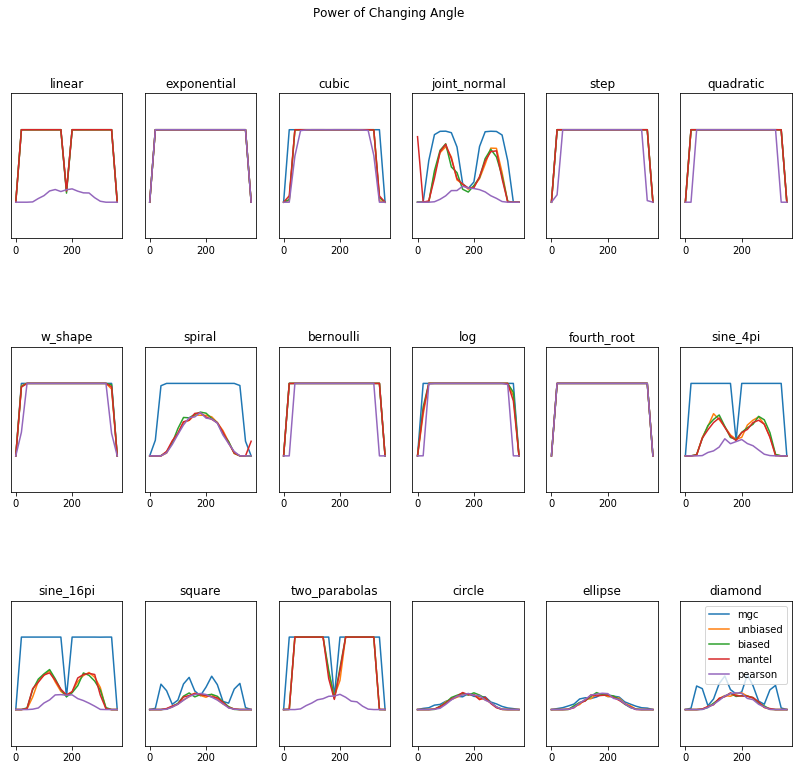

In [9]:
plot_all_curves()